# Drainage
We need to salute the lady of the lake

In [ ]:
#| default_exp hydrology

# Hydrology System Design Document

## Overview
Create a comprehensive drainage and watershed analysis system that visualizes how water flows across terrain, including rivers, lakes, and watershed boundaries.

## File Structure
```
hydrology.py  # New file for drainage/watershed analysis
├── Lake detection and management
├── Watershed computation
├── Drainage network tracing
└── Rendering utilities
```

## Core Concepts

### 1. Lakes
**Definition**: Land hexes that are local minima - water cannot flow downhill to escape.

**Detection**:
- A hex is a lake if `elevation > 0` AND all neighbors have `elevation >= current`
- Multi-hex lakes: Adjacent local minima should merge into single lake bodies
- Endorheic basins: Watersheds that terminate at lakes instead of ocean

**Lake Class**:
```python
@dataclass
class Lake:
    hexes: set[int]  # All hexes in this lake body
    surface_elevation: float  # Water surface level
    watershed_id: int  # Links to watershed that drains here
    overflow_point: int = None  # Lowest point on lake edge (for future overflow)
```

### 2. Watersheds
**Definition**: A group of hexes that all drain to the same terminal point (ocean outlet or lake).

**Types**:
- **Ocean watersheds**: Drain to ocean (most common)
- **Lake watersheds**: Drain to an interior lake (endorheic)

**Watershed Class**:
```python
@dataclass
class Watershed:
    terminal_hex: int  # Ocean hex or lake hex
    land_hexes: list[int]  # All hexes that drain here
    drainage_paths: dict[int, list[int]]  # source_hex -> path to terminal
    color: str  # Categorical color from seaborn palette
    is_lake_basin: bool = False
    lake: Lake = None  # If this is a lake watershed
```

### 3. Drainage Networks
**Definition**: The complete set of flow paths from every land hex to its terminal point.

**Properties**:
- Every land hex traces downhill until hitting ocean or lake
- Path stores intermediate hexes for river rendering
- Accumulates flow for width calculations

## Key Algorithms

### Algorithm 1: Find Lakes
```python
def find_lakes(terrain: Terrain) -> dict[int, Lake]:
    """
    Detect all lakes (local minima) and merge adjacent ones.
    
    Returns:
        {lake_id: Lake} - One entry per distinct lake body
    """
    # Step 1: Find all local minima
    local_minima = set()
    for i in land_hexes:
        lowest_neighbor = terrain.lowest_neighbor(i)
        if lowest_neighbor is None or terrain.elevations[lowest_neighbor] >= terrain.elevations[i]:
            local_minima.add(i)
    
    # Step 2: Merge adjacent minima using flood fill
    lakes = {}
    visited = set()
    lake_id = 0
    
    for seed in local_minima:
        if seed in visited:
            continue
        
        # Flood fill at this elevation
        lake_hexes = set()
        queue = [seed]
        elevation = terrain.elevations[seed]
        
        while queue:
            current = queue.pop(0)
            if current in visited:
                continue
            if terrain.elevations[current] != elevation:
                continue
            
            lake_hexes.add(current)
            visited.add(current)
            
            # Add neighbors at same elevation
            for neighbor in terrain.ring(current, 1):
                if neighbor in local_minima:
                    queue.append(neighbor)
        
        lakes[lake_id] = Lake(
            hexes=lake_hexes,
            surface_elevation=elevation,
            watershed_id=lake_id
        )
        lake_id += 1
    
    return lakes
```

### Algorithm 2: Compute Watersheds
```python
def compute_watersheds(terrain: Terrain) -> dict[int, Watershed]:
    """
    Trace drainage from every land hex to terminal point.
    Group by terminal to form watersheds.
    
    Returns:
        {watershed_id: Watershed}
    """
    lakes = find_lakes(terrain)
    lake_hex_to_id = {}  # Reverse lookup
    for lake_id, lake in lakes.items():
        for hex in lake.hexes:
            lake_hex_to_id[hex] = lake_id
    
    # Trace every land hex
    terminal_map = {}  # land_hex -> (terminal_hex, path)
    
    for i in land_hexes:
        if i in lake_hex_to_id:
            # This hex IS a lake - it's its own terminal
            terminal_map[i] = (i, [i])
            continue
        
        path = [i]
        current = i
        visited = {i}
        
        while True:
            # Check if we hit a lake
            if current in lake_hex_to_id:
                terminal_map[i] = (current, path)
                break
            
            lowest = terrain.lowest_neighbor(current)
            
            # Dead end or loop
            if lowest is None or lowest in visited:
                terminal_map[i] = (current, path)
                break
            
            # Hit ocean
            if terrain.elevations[lowest] <= 0:
                terminal_map[i] = (lowest, path)
                break
            
            path.append(lowest)
            visited.add(lowest)
            current = lowest
    
    # Group by terminal
    watersheds_by_terminal = {}
    for land_hex, (terminal, path) in terminal_map.items():
        if terminal not in watersheds_by_terminal:
            watersheds_by_terminal[terminal] = {
                'land_hexes': [],
                'paths': {}
            }
        watersheds_by_terminal[terminal]['land_hexes'].append(land_hex)
        watersheds_by_terminal[terminal]['paths'][land_hex] = path
    
    # Create Watershed objects with colors
    colors = get_watershed_colors(len(watersheds_by_terminal))
    watersheds = {}
    
    for watershed_id, (terminal, data) in enumerate(watersheds_by_terminal.items()):
        is_lake = terminal in lake_hex_to_id
        
        watersheds[watershed_id] = Watershed(
            terminal_hex=terminal,
            land_hexes=data['land_hexes'],
            drainage_paths=data['paths'],
            color=colors[watershed_id],
            is_lake_basin=is_lake,
            lake=lakes[lake_hex_to_id[terminal]] if is_lake else None
        )
    
    return watersheds
```

### Algorithm 3: River Width from Gradient
```python
def compute_gradient_width(terrain: Terrain, path: list[int], 
                          min_width: float, max_width: float) -> list[float]:
    """
    Calculate river width at each segment based on elevation gradient.
    Steep = thick, gentle = thin.
    """
    widths = []
    
    # Find max gradient across all terrain for normalization
    max_gradient = 0
    for i in range(len(path) - 1):
        current = path[i]
        next_hex = path[i + 1]
        
        elev_drop = abs(terrain.elevations[current] - terrain.elevations[next_hex])
        distance = terrain.hexGrid.radius * 2  # Approximate hex-to-hex distance
        gradient = elev_drop / distance
        max_gradient = max(max_gradient, gradient)
    
    # Calculate width for each segment
    for i in range(len(path) - 1):
        current = path[i]
        next_hex = path[i + 1]
        
        elev_drop = abs(terrain.elevations[current] - terrain.elevations[next_hex])
        distance = terrain.hexGrid.radius * 2
        gradient = elev_drop / distance
        
        # Normalize and scale
        normalized = gradient / max_gradient if max_gradient > 0 else 0
        width = min_width + normalized * (max_width - min_width)
        widths.append(width)
    
    return widths
```

## Rendering Modes

### Mode 1: "drainage"
Shows complete drainage network colored by watershed.

**Render steps**:
1. Compute watersheds
2. For each watershed:
   - Fill lake hexes (if present) with watershed color
   - Draw all drainage paths as rivers, colored by watershed
   - River width based on gradient

### Mode 2: "watersheds"
Shows watershed boundaries only (like topographic maps).

**Render steps**:
1. Compute watersheds
2. Find boundary hexes (neighbors belong to different watersheds)
3. Draw boundary lines between watersheds

### Mode 3: "flow_accumulation"
Heatmap showing how many upstream hexes drain through each point.

**Render steps**:
1. Compute watersheds
2. For each hex, count upstream contributors
3. Color by accumulation (blue = low, red = high)

## Configuration

```python
@dataclass
class HydroRenderConfig:
    mode: str = "drainage"  # "drainage", "watersheds", "flow_accumulation"
    
    # Rivers
    show_major_rivers_only: bool = False
    major_river_threshold: int = 5  # min path length
    width_mode: str = "gradient"  # "gradient", "flow", "constant"
    river_min_width: float = 1.0
    river_max_width: float = 6.0
    
    # Lakes
    show_lakes: bool = True
    darken_lakes: bool = True  # Make lake slightly darker than watershed color
    lake_darken_factor: float = 0.8  # Multiply RGB by this
    
    # Colors
    palette: str = "tab20"  # Seaborn palette name
    
    # Display
    show_legend: bool = True
```

## Integration with Existing Code

### StyleCSS Integration
Use `StyleCSS.seaborn()` to generate watershed colors:
```python
def get_watershed_colors(n_watersheds: int, palette: str = "tab20") -> list[str]:
    """Generate N distinct colors using seaborn palette."""
    styles = StyleCSS.seaborn(palette, levels=n_watersheds)
    return [style.properties['fill'] for style in styles]
```

### Terraform Integration
Add hydro rendering to `Terraform.render_climate()`:
```python
if config.hydro is not None:
    hydro_layer = self.render_hydro(config.hydro)
    ret += hydro_layer
```

## Future Enhancements

1. **Lake overflow**: When lakes fill, find lowest point on edge to create outlet
2. **Seasonal variation**: Adjust river width by precipitation season
3. **Confluence highlighting**: Mark where major tributaries join
4. **Watershed statistics**: Area, total flow, average elevation
5. **Interactive**: Click watershed to highlight its drainage basin

## Testing Strategy

1. **Synthetic terrains**: Create known patterns (single peak, valley, basin)
2. **Lake detection**: Verify multi-hex lakes merge correctly
3. **Watershed count**: Should match number of ocean outlets + interior lakes
4. **Flow conservation**: Every land hex should drain somewhere
5. **Visual inspection**: Compare with real-world drainage patterns (Maui, California)

## Prior Art

In [ ]:
#| export
import numpy as np
import sys
import os
import math
import random

#data
from collections import namedtuple
from dataclasses import dataclass,  field, asdict
from typing import List
from enum import Enum

#Jeremy
from dialoghelper import * 
from fastcore.basics import patch
from fasthtml.common import *
from fasthtml.jupyter import *
import httpx

#custom
import copy

In [ ]:
#| export


from HexMagic.styles import StyleCSS, SVGBuilder, SVGLayer, SVGPatternLoader, preview, app, StyleDemo, LayerAnimation
from HexMagic.primitives import MapCord, MapSize, MapRect, MapPath, Hex, HexGrid, HexWrapper, HexPosition, hexBackground, HexRegion
from HexMagic.terrain import  TerraDemo, Terrain, GeoBounds, ClimatePreset
from HexMagic.terrainpatterns import TerrainPatterns, SVGMask
from HexMagic.climate import Climate, TerrainFactory
from HexMagic.river import River, RiverDemo

## Helpers

In [ ]:
#| export
@patch
def simpleIsland(demo:TerraDemo,debug = False):


    # 1. Create blank ocean world with tropical preset
    bounds = MapRect(MapCord(0, 0), MapSize(800, 800))


    terrain, plates = TerrainFactory.create_ocean_world(
        bounds=bounds,
        preset='monsoon',
        radius=15,
        lon_span=5.0,
        num_plates=16,
        ocean_fraction=0.6,
        debug= debug
    )

    terrain.climate.configure(terrain,debug=debug)

    return terrain

## Climate interaction

In [ ]:
#| export
#find_river_sources() - source detection
@patch
def find_river_sources(self: Terrain, 
                       min_precipitation=500,   # mm/year
                       min_elevation=500,       # meters
                       top_n=20,
                       debug = False):               # Return top N sources
    """
    Find potential river source locations based on precipitation and elevation.
    
    Good sources have:
    - High precipitation (rain/snowmelt)
    - High elevation (mountains to flow down from)
    - Not ocean
    
    Returns list of (hex_index, score) tuples sorted by score.
    """
    if 'precipitation' not in self.fields:
        raise ValueError("Must compute precipitation first (compute_precipitation_sb)")
    
    sources = []
    
    for i in range(len(self.elevations)):
        elev = self.elevations[i]
        precip = self.fields['precipitation'][i]
        
        # Skip ocean
        if elev <= 0:
            continue
        
        # Check thresholds
        if precip >= min_precipitation and elev >= min_elevation:
            # Score = precipitation * elevation (higher = better source)
            score = precip * (elev / 1000.0)  # Normalize elevation
            sources.append((i, precip, elev, score))
    
    # Sort by score descending
    sources.sort(key=lambda x: x[3], reverse=True)
    if debug:
        print(f"\n=== RIVER SOURCE ANALYSIS ===")
        print(f"Found {len(sources)} potential sources (precip >= {min_precipitation}mm, elev >= {min_elevation}m)")
    
        if sources:
            print(f"\nTop {min(top_n, len(sources))} sources:")
            print(f"{'Rank':<6} {'Hex':<8} {'Precip':<12} {'Elev':<10} {'Score':<10}")
            print("-" * 50)
            for rank, (idx, precip, elev, score) in enumerate(sources[:top_n], 1):
                print(f"{rank:<6} {idx:<8} {precip:<12.0f} {elev:<10.0f} {score:<10.1f}")
    
    return sources

In [ ]:
#| export
# visualize_river_sources() - source visualization
@patch
def visualize_river_sources(self: Terrain,
                            min_precipitation=500,
                            min_elevation=500,
                            layer_name="river_sources"):
    """Visualize potential river source locations on the map."""
    
    sources = self.find_river_sources(min_precipitation, min_elevation)
    
    if not sources:
        print("No sources found with current thresholds")
        return
    
    # Create a field marking source strength
    source_field = np.zeros(len(self.elevations))
    
    # Normalize scores for visualization
    max_score = sources[0][3] if sources else 1
    for idx, precip, elev, score in sources:
        source_field[idx] = score / max_score  # 0-1 normalized
    
    # Create color gradient (blue = strong source)
    colors = ["#ffffff", "#e3f2fd", "#90caf9", "#42a5f5", "#1e88e5", "#1565c0"]
    thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
    
    # Bin sources
    source_indices = np.digitize(source_field, thresholds)
    source_indices = np.clip(source_indices, 0, len(colors) - 1)
    
    # Only show hexes that are actual sources
    source_set = {s[0] for s in sources}
    for i in range(len(source_indices)):
        if i not in source_set:
            source_indices[i] = 0  # White/transparent for non-sources
    
    # Create patterns
    patternGen = TerrainPatterns(self)
    patterns = patternGen.ballDensity(len(colors), fills=colors, prefix="source")
    
    # Generate overlay
    overlay = self.makeOverlay(source_indices, patterns)
    self.builder.adjust(layer_name, overlay)
    
    return sources


In [ ]:
#    precipitation_elevation_summary() - analysis for river planning
    

In [ ]:
#| export
#create_valley_river() - river creation
@patch
def create_valley_river(self: Terrain, source_hex, valley_floor=20):
    """Create river that flows through the valley."""
    path = [source_hex]
    current = source_hex
    accumulated_flow = self.fields['precipitation'][source_hex]
    
    visited = {source_hex}
    max_length = 100  # Prevent infinite loops
    
    while len(path) < max_length:
        lowest = self.lowest_neighbor(current)
        
        # Stop conditions
        if lowest is None:
            break
        if lowest in visited:  # Prevent loops
            break
        if self.elevations[lowest] < 1:  # Hit ocean
            path.append(lowest)
            break
            
        # Add rainfall contribution
        accumulated_flow += self.fields['precipitation'][lowest]
        path.append(lowest)
        visited.add(lowest)
        current = lowest
        
        # Continue through valley (lower threshold)
        if self.elevations[current] < valley_floor:
            # In valley - keep going to find outlet
            continue
    
    if len(path) < 3:
        return None
        
    river = River(self)
    path.reverse()
    river.tree.create_node(tag="segment", identifier=0, data=path)
    river.hexes.update(path)
    river.accumulated_rainfall = accumulated_flow
    
    return river

In [ ]:
#| export
#calculate_flow_from_rivers() - flow calculation from rivers
@patch
def calculate_flow_from_rivers(self: Terrain, rivers: list):
    """Populate flow and flow_direction fields from River objects."""
    n_hexes = len(self.elevations)
    
    # Initialize fields
    self.fields['flow'] = np.zeros(n_hexes)
    self.fields['flow_direction'] = np.array([None] * n_hexes, dtype=object)
    
    for river in rivers:
        # Calculate flow for this river
        river_flow = river._calculate_flow()
        
        # Add to terrain fields
        for hex_idx, flow_count in river_flow.items():
            self.fields['flow'][hex_idx] += flow_count
        
        # Set directions from river tree
        for node in river.tree.all_nodes():
            segment = node.data
            # Each hex flows to the previous one in the segment (toward outlet)
            for i in range(len(segment) - 1, 0, -1):
                current_hex = segment[i]
                next_hex = segment[i - 1]
                
                # Convert to HexPosition direction
                direction = self.hexGrid.index_to_hexposition(next_hex, current_hex)
                self.fields['flow_direction'][current_hex] = direction

In [ ]:
#| export
#downsample_rivers_simple() - river downsampling
@patch
def downsample_rivers_simple(self: Terrain, sample_radius=2):
    """Downsample river flow amounts only. Directions will be recalculated from elevation."""
    old_grid = self.hexGrid
    factor = sample_radius + 1
    
    if 'flow' not in self.fields:
        return None
    
    new_flow = []
    
    for new_row in range(old_grid.nRows // factor):
        for new_col in range(old_grid.nCols // factor):
            # Find all old hexes in this region
            old_hexes = []
            for dr in range(factor):
                for dc in range(factor):
                    old_row = new_row * factor + dr
                    old_col = new_col * factor + dc
                    if old_row < old_grid.nRows and old_col < old_grid.nCols:
                        old_idx = old_grid.row_col_to_index(old_row, old_col)
                        if old_idx >= 0:
                            old_hexes.append(old_idx)
            
            # Sum flow (accumulated rainfall/drainage)
            total_flow = sum(self.fields['flow'][h] for h in old_hexes)
            new_flow.append(total_flow)
    
    return np.array(new_flow)

In [ ]:
#| export
#  trace_rivers_from_flow() - river tracing
@patch
def trace_rivers_from_flow(self: Terrain, min_flow=10, max_rivers=20):
    """Create rivers by tracing downhill from high-flow hexes."""
    if 'flow' not in self.fields:
        raise ValueError("Must have flow field")
    
    # Find high-flow sources
    sources = []
    for i in range(len(self.fields['flow'])):
        if self.fields['flow'][i] >= min_flow and self.elevations[i] > 0:
            sources.append((i, self.fields['flow'][i]))
    
    sources.sort(key=lambda x: x[1], reverse=True)
    sources = sources[:max_rivers]
    
    rivers = []
    for source_idx, flow in sources:
        path = [source_idx]
        current = source_idx
        visited = {source_idx}
        ocean_outlet = None  # Track if we hit ocean
        
        # Follow downhill gradient
        while len(path) < 100:  # Safety limit
            lowest = self.lowest_neighbor(current)
            
            # Stop conditions
            if lowest is None:
                break
            if lowest in visited:
                break
            if self.elevations[lowest] <= 0:  # Hit ocean
                ocean_outlet = lowest  # Remember which ocean hex
                break
            
            path.append(lowest)
            visited.add(lowest)
            current = lowest
        
        if len(path) >= 3:
            river = River(self)
            path.reverse()  # Root at outlet
            river.tree.create_node(tag="segment", identifier=0, data=path)
            river.hexes.update(path)
            
           
            river.ocean_outlet = ocean_outlet
            
            rivers.append(river)
    
    return rivers

### resample

## River Downsampling - Key Learnings

### The Problem
When downsampling terrain with rivers, we tried to preserve **HexPosition directions** (q, r, s cube coordinates) across grid scales. This failed because:

1. **Directions are relative to grid structure** - A direction like `(1, -1, 0)` means "one hex northeast" but when applied to a smaller grid, it can point out of bounds
2. **Edge hexes lose neighbors** - After downsampling, hexes near edges may not have valid neighbors in the direction that existed in the original grid

### What Didn't Work
```python
# Storing directions and trying to replay them in new grid
terrain.fields['flow_direction'][hex] = HexPosition(q, r, s)
# Later in downsampled grid:
next_hex = smaller.hexGrid.hexposition_to_index(direction, current)  # Returns -1!
```

### What Works: Simple Flow Amount + Elevation Gradient
The solution was to **only preserve flow amounts** and **regenerate directions from elevation**:

1. **`downsample_rivers_simple()`** - Just sums flow values per region (no directions)
2. **`trace_rivers_from_flow()`** - Finds high-flow hexes and traces downhill using `lowest_neighbor()`

This works because:
- Flow amounts indicate river importance/size
- Elevation gradient is preserved through downsampling (using max)
- Rivers naturally follow terrain - no coordinate conversion needed

### Key Insight
> Since elevation is downsampled too, the gradient comes "for free" - we don't need to preserve directions at all.a

## Watershed

In [ ]:
#| export
@dataclass
class Watershed:
    region: HexRegion  # All hexes that drain here
    tributary: River  # Rivers that make up this watershed
    style: StyleCSS  # Categorical color from seaborn palette
    terrain:Terrain

    def __init__(self, region: HexRegion, tributary: River, style: StyleCSS):
        self.region = region
        self.tributary = tributary
        self.style = style
        self.terrain = tributary.terrain


    @property
    def terminal_hex(self) -> int:
        """Find the hex with lowest elevation in this watershed.
        
        Returns:
            Index of the lowest hex
        """
        if not self.region.hexes:
            return None
        
        terrain = self.tributary.terrain
        lowest_idx = None
        lowest_elev = float('inf')
        
        for hex_idx in self.region.hexes:
            elev = terrain.elevations[hex_idx]
            if elev < lowest_elev:
                lowest_elev = elev
                lowest_idx = hex_idx
        
        return lowest_idx

    @property
    def is_ocean(self) -> bool:
        """Check if this watershed drains to the ocean.
        
        Returns:
            True if the lowest hex has elevation <= 0 (ocean)
        """
        lowest = self.terminal_hex
        if lowest is None:
            return False
        
        terrain = self.tributary.terrain
        return terrain.elevations[lowest] <= 0


    @classmethod
    def river_peak(cls, terrain, peak_index):
        """Create a Watershed by tracing downhill from a peak."""
        
        # Trace downhill
        path = [peak_index]
        current = peak_index
        ocean_outlet = None
        
        while True:
            lowest = terrain.lowest_neighbor(current)
            if lowest is None:
                break
            if terrain.elevations[lowest] <= 0:
                ocean_outlet = lowest
                path.append(lowest)
                break
            path.append(lowest)
            current = lowest
        
        if len(path) < 2:
            return None
        
        # Build River
        path.reverse()
        river = River(terrain)
        river.tree.create_node(tag="segment", identifier=0, data=path)
        river.hexes.update(path)
        river.ocean_outlet = ocean_outlet
        
        # Wrap in Watershed
        region = HexRegion(hexes=river.hexes.copy(), hex_grid=terrain.hexGrid)
        style = StyleCSS("default", fill="#cccccc")  # Placeholder, assigned later
        
        return cls(region=region, tributary=river, style=style)

    @classmethod
    def from_peak(cls, terrain, peak_index):
        """Create a river by tracing downhill from a peak."""
        
        # Trace downhill to find the outlet first
        path = [peak_index]
        current = peak_index
        ocean_outlet = None  # Track which ocean hex we hit
        
        while True:
            lowest = terrain.lowest_neighbor(current)
            # Stop if local minimum
            if lowest is None:
                break
            
            # Check if we hit ocean
            if terrain.elevations[lowest] <= 0:
                ocean_outlet = lowest  # Remember the ocean hex
                path.append(lowest)    # ← ADD THIS LINE
                break
            
            path.append(lowest)
            current = lowest
        
        # Don't create river if path is too short
        if len(path) < 2:
            return None
        
        # Build tree from outlet (root) upward
        path.reverse()
        
        river = River(terrain)
        river.tree.create_node(tag="segment", identifier=0, data=path)
        river.hexes.update(path)
        river.ocean_outlet = ocean_outlet  # Store which ocean hex we flow to
        
        return river
        
    
    @classmethod
    def compute_all(cls, terrain: Terrain, num_peaks: int = 50, min_height: int = 1, debug: bool = False) -> list['Watershed']:
        """Compute all watersheds by:
        1. Find peaks and create rivers
        2. Merge rivers using River.combine_rivers()
        3. Assign each land hex to the river it flows into
        """
        
        # Step 1: Find peaks and create rivers
        sources = terrain.find_river_sources(
        min_precipitation=terrain.climate.precip_bins[0],  # Use first bin
        min_elevation=100,
        top_n=num_peaks
        )
        peaks = [idx for idx, precip, elev, score in sources]

        rivers = [River.from_peak(terrain, peak) for peak in peaks]
        rivers = [r for r in rivers if r is not None]
        
        if debug:
            print(f"\n=== STEP 1: Created {len(rivers)} rivers from {len(peaks)} peaks ===")
            for i, river in enumerate(rivers[:5]):  # Show first 5
                print(f"  River {i}: {len(river.hexes)} hexes, outlet={river.ocean_outlet}")
        
        # Step 2: Merge intersecting rivers
        merged_rivers = River.combine_rivers(rivers)
        
        if debug:
            print(f"\n=== STEP 2: Merged to {len(merged_rivers)} rivers ===")
            for i, river in enumerate(merged_rivers):
                outlet_type = "ocean" if river.ocean_outlet is not None else "lake/none"
                print(f"  River {i}: {len(river.hexes)} hexes, outlet={outlet_type}")
        
        # Step 3: For each land hex, trace downhill to find which river it flows to
        hex_to_river = {}  # hex_idx -> river_index
        unassigned = []  # Track hexes that don't reach any river
        
        for i in range(len(terrain.elevations)):
            if terrain.elevations[i] <= 0:
                continue  # Skip ocean
            
            # Trace downhill until we hit a river or ocean
            current = i
            visited = {i}
            path_length = 0
            
            while True:
                # Check if current hex is in any river
                for river_idx, river in enumerate(merged_rivers):
                    if current in river.hexes:
                        hex_to_river[i] = river_idx
                        break
                
                if i in hex_to_river:
                    break
                
                # Move downhill
                lowest = terrain.lowest_neighbor(current)
                if lowest is None or lowest in visited:
                    unassigned.append((i, "local_minimum", path_length))
                    break  # Local minimum (lake)
                if terrain.elevations[lowest] <= 0:
                    unassigned.append((i, "ocean_direct", path_length))
                    break  # Hit ocean without hitting river
                
                visited.add(lowest)
                current = lowest
                path_length += 1
                
                if path_length > 100:  # Safety
                    unassigned.append((i, "too_long", path_length))
                    break
        
        if debug:
            print(f"\n=== STEP 3: Traced {len(hex_to_river)} land hexes to rivers ===")
            print(f"  Unassigned: {len(unassigned)} hexes")
            
            # Show breakdown of unassigned reasons
            from collections import Counter
            reasons = Counter(reason for _, reason, _ in unassigned)
            for reason, count in reasons.items():
                print(f"    {reason}: {count}")
            
            # Show which rivers got the most drainage
            river_sizes = {}
            for hex_idx, river_idx in hex_to_river.items():
                river_sizes[river_idx] = river_sizes.get(river_idx, 0) + 1
            
            print(f"\n  Top 5 watersheds by drainage area:")
            for river_idx, count in sorted(river_sizes.items(), key=lambda x: x[1], reverse=True)[:5]:
                river_hexes = len(merged_rivers[river_idx].hexes)
                print(f"    River {river_idx}: {count} drainage hexes + {river_hexes} river hexes = {count + river_hexes} total")
        
        # Step 4: Create watersheds from rivers + assigned hexes
        colors = StyleCSS.seaborn("tab20", levels=20)
        watersheds = []
        
        for river_idx, river in enumerate(merged_rivers):
            # Collect all hexes that flow to this river
            basin_hexes = set(river.hexes)
            for hex_idx, assigned_river in hex_to_river.items():
                if assigned_river == river_idx:
                    basin_hexes.add(hex_idx)
            
            region = HexRegion(hexes=basin_hexes, hex_grid=terrain.hexGrid)
            style = colors[river_idx % len(colors)]
            river.terrain = terrain
            
            
            watershed = cls(
                region=region,
                tributary=river,
                style=style
            )
            watersheds.append(watershed)
        
        if debug:
            print(f"\n=== STEP 4: Created {len(watersheds)} watersheds ===")
            total_assigned = sum(len(w.region.hexes) for w in watersheds)
            total_land = sum(1 for e in terrain.elevations if e > 0)
            print(f"  Total coverage: {total_assigned}/{total_land} land hexes ({100*total_assigned/total_land:.1f}%)")
            for i, watershed in enumerate(watersheds):
                print(f"  Watershed {i}: {len(watershed.region.hexes)} hexes, {watershed.tributary.terrain}")

        
        
        return watersheds





In [ ]:
#| export
@patch
def simplify(self: Watershed, k: int = 3) -> 'Watershed':
    """Simplify watershed to k longest paths.
    
    Strategy:
    1. Find all leaf-to-terminal paths in the river tree
    2. Sort by length, keep top k
    3. For each of the k paths, trace a river from its highest hex
    4. Merge all k rivers together
    
    Args:
        k: Number of major tributaries to keep
        
    Returns:
        New Watershed with simplified river network
    """
    terrain = self.tributary.terrain
    
    # Step 1: Find all paths from leaves to root
    all_paths = []
    
    for node in self.tributary.tree.all_nodes():
        # Only start from leaves
        if self.tributary.tree.children(node.identifier):
            continue
        
        # Trace path from this leaf to root
        path = []
        current = node
        
        while current is not None:
            path.extend(current.data)
            parent_id = current.predecessor(self.tributary.tree.identifier)
            current = self.tributary.tree.get_node(parent_id) if parent_id else None
        
        all_paths.append(path)
    
    # Step 2: Sort by length and keep top k
    all_paths.sort(key=len, reverse=True)
    top_paths = all_paths[:k]
    
    # Step 3: Build k rivers from each path's highest hex
    rivers = []
    for path in top_paths:
        highest_hex = max(path, key=lambda h: terrain.elevations[h])
        new_river = Watershed.from_peak(terrain, highest_hex)
        if new_river is not None:
            rivers.append(new_river)
    
    # Step 4: Merge all rivers
    if not rivers:
        return self  # Fallback
    
    merged_rivers = River.combine_rivers(rivers)
    
    if not merged_rivers:
        return self
    
    # Take the largest merged river
    main_river = max(merged_rivers, key=lambda r: len(r.hexes))
    main_river.terrain = terrain
    
    # Create new region with all hexes from simplified rivers
    new_region = HexRegion(
        hexes=main_river.hexes.copy(),
        hex_grid=terrain.hexGrid
    )
    
    return Watershed(
        region=new_region,
        tributary=main_river,
        style=self.style
    )


In [ ]:
#| export
@patch
def segments(self: Watershed) -> list[list[int]]:
    """Extract hex segments from river tree, sorted high→low elevation.
    
    Each segment includes connection to parent (if any) at the start.
    
    Returns:
        List of hex index lists, each representing a connected branch/segment
    """
    terrain = self.tributary.terrain
    result = []
    
    for node in self.tributary.tree.all_nodes():
        # Get land hexes only
        land_hexes = [h for h in node.data if terrain.elevations[h] > 0]
        
        # Add ocean terminal if this is root and drains to ocean
        if node.identifier == self.tributary.tree.root and self.is_ocean:
            if self.terminal_hex is not None:
                land_hexes.append(self.terminal_hex)
        
        if len(land_hexes) >= 2:
            # If this node has a parent, prepend the connection point
            parent_id = node.predecessor(self.tributary.tree.identifier)
            if parent_id is not None:
                parent_node = self.tributary.tree.get_node(parent_id)
                # Last hex of parent is the connection point
                connection_hex = parent_node.data[-1]
                land_hexes.insert(0, connection_hex)
            
            # Sort by elevation: highest first
            land_hexes.sort(key=lambda h: terrain.elevations[h], reverse=True)
            result.append(land_hexes)
    
    return result

In [ ]:
#| export
@patch
def segment_to_points(self: Watershed, hexes: list[int]) -> list[MapCord]:
    """Convert hex indices to drawable points, handling ocean termination.
    
    If last hex is at/below sea level, use midpoint between it and 
    the last land hex instead of ocean hex center.
    
    Args:
        hexes: List of hex indices (high→low elevation)
        
    Returns:
        List of MapCord points for drawing
    """
    terrain = self.tributary.terrain
    grid = terrain.hexGrid
    
    if not hexes:
        return []
    
    points = []
    
    # Find first underwater hex (if any)
    ocean_idx = None
    for i, h in enumerate(hexes):
        if terrain.elevations[h] <= 0:
            ocean_idx = i
            break
    
    if ocean_idx is None:
        # No ocean - just use all hex centers
        for h in hexes:
            points.append(grid.hexes[h].center)
    else:
        # Add land hex centers up to (but not including) ocean
        for h in hexes[:ocean_idx]:
            points.append(grid.hexes[h].center)
        
        # Add midpoint between last land hex and ocean hex
        if ocean_idx > 0:
            last_land = grid.hexes[hexes[ocean_idx - 1]].center
            ocean_hex = grid.hexes[hexes[ocean_idx]].center
            midpoint = MapCord(
                (last_land.x + ocean_hex.x) / 2,
                (last_land.y + ocean_hex.y) / 2
            )
            points.append(midpoint)
    
    return points

In [ ]:
#| export
#using helper functions
@patch
def draw(self: Watershed, 
         min_width: float = 1.0,
         max_width: float = 8.0,
         min_windiness: float = 0.05,
         max_windiness: float = 0.3,
         min_iterations: int = 2,
         max_iterations: int = 5,
         color: str = "#1565c0",
         opacity: float = 0.7,
         debug: bool = False) -> str:
    """Render river with flow-based thickness and gradient-based windiness."""
    
    flows = self.tributary._calculate_flow()
    if not flows:
        return ""
    
    terrain = self.tributary.terrain
    max_flow = max(flows.values())
    log_max_flow = math.log10(max_flow + 1)
    
    ret = ""
    
    for hexes in self.segments():
        points = self.segment_to_points(hexes)
        
        if len(points) < 2:
            continue
        
        # Calculate gradient from elevation difference
        land_hexes = [h for h in hexes if terrain.elevations[h] > 0]
        if len(land_hexes) >= 2:
            gradient = terrain.elevations[land_hexes[0]] - terrain.elevations[land_hexes[-1]]
        else:
            gradient = 0
        
        # Calculate average flow (log scaled)
        segment_flows = [flows.get(h, 1) for h in land_hexes]
        avg_flow = sum(segment_flows) / len(segment_flows) if segment_flows else 1
        log_flow = math.log10(avg_flow + 1)
        flow_ratio = log_flow / log_max_flow if log_max_flow > 0 else 0
        
        # Map flow to width
        width = round(min_width + flow_ratio * (max_width - min_width), 1)
        
        # Map gradient to windiness (high gradient = less windy)
        max_possible_gradient = max(terrain.elevations) - min(e for e in terrain.elevations if e > 0)
        if max_possible_gradient > 0:
            gradient_ratio = min(gradient / max_possible_gradient, 1.0)
            windiness_ratio = 1.0 - gradient_ratio
        else:
            windiness_ratio = 0.5
        
        offset_factor = min_windiness + windiness_ratio * (max_windiness - min_windiness)
        iterations = int(min_iterations + windiness_ratio * (max_iterations - min_iterations))
        
        if debug:
            print(f"Segment: {len(hexes)} hexes, gradient={gradient:.0f}, "
                  f"width={width:.1f}, windiness={offset_factor:.2f}")
        
        # Create and draw path
        aPath = MapPath(points, style=StyleCSS("dummy"))
        windy = aPath.make_windy(iterations=iterations, offset_factor=offset_factor)
        
        inline_style = f"fill:none;stroke:{color};stroke-width:{width};opacity:{opacity}"
        ret += windy.drawSpline(adds=f'style="{inline_style}"')
    
    return ret

### Drainage

In [ ]:
#| export
class DrainageBasins:

    def __init__(self,terrain: Terrain,debug=False):
        self.terrain = terrain
        self.sheds = Watershed.compute_all(terrain,debug=debug)

In [ ]:
#| export
@patch
def watershed_overlay(self:DrainageBasins):
    """Demo showing watersheds colored by drainage basin."""

    # Create overlay for watershed colors
    overlay = ""
    
    for i, watershed in enumerate(self.sheds):
        # Add this watershed's style to builder
        self.terrain.hexGrid.builder.add_style(watershed.style)
        
        # Draw all hexes in this watershed's region
        for hex_idx in watershed.region.hexes:
            hex_obj = self.terrain.hexGrid.hexes[hex_idx]
            overlay += f"\t{hex_obj.svg()}\n".replace(
                hex_obj.style.name, 
                watershed.style.name
            )
    
    # Add watershed overlay as new layer
    return overlay
    
@patch
def boundary_overlay(self:DrainageBasins,
                boundary_style = StyleCSS("watershed_boundary", 
                             fill="none", 
                             stroke="#000000", 
                             stroke_width=2,
                             opacity=0.8)):
    # Optionally draw watershed boundaries
    overlay = ""
    self.terrain.hexGrid.builder.add_style(boundary_style)
    
    for watershed in self.sheds:
        paths = watershed.region.trace_perimeter(style=boundary_style)
        for path in paths:
            overlay += path.svg()
    
    return overlay


## layers

In [ ]:
#| export
@patch
def gradient_overlay(self: DrainageBasins,
                     min_width: float = 0.5,
                     max_width: float = 4.0,
                     opacity: float = 0.6):
    """Create overlay showing flow direction with gradient-based line widths.
    
    Each line segment:
    - Connects a land hex to its downhill neighbor
    - Colored by watershed
    - Width scaled by elevation gradient (steeper = thicker)
    
    Args:
        min_width: Minimum line width (for flat areas)
        max_width: Maximum line width (for steep slopes)
        opacity: Line opacity (0-1)
    
    Returns:
        SVG string of line segments
    """
    terrain = self.terrain
    
    # First pass: calculate all gradients to find max for normalization
    gradients = []
    flow_data = []  # Store (hex_idx, neighbor_idx, gradient, watershed_idx)
    
    # Map each hex to its watershed
    hex_to_watershed = {}
    for i, watershed in enumerate(self.sheds):
        for hex_idx in watershed.region.hexes:
            hex_to_watershed[hex_idx] = i
    
    for hex_idx in hex_to_watershed.keys():
        # Find lowest neighbor (flow direction)
        lowest = terrain.lowest_neighbor(hex_idx)
        
        if lowest is None or terrain.elevations[lowest] <= 0:
            continue  # Skip if no downhill or flows to ocean
        
        # Calculate gradient
        elev_current = terrain.elevations[hex_idx]
        elev_next = terrain.elevations[lowest]
        elev_drop = elev_current - elev_next
        
        # Distance between hex centers
        hex_obj = terrain.hexGrid.hexes[hex_idx]
        neighbor_obj = terrain.hexGrid.hexes[lowest]
        distance = hex_obj.center.distance(neighbor_obj.center)
        
        gradient = elev_drop / distance if distance > 0 else 0
        gradients.append(gradient)
        
        watershed_idx = hex_to_watershed[hex_idx]
        flow_data.append((hex_idx, lowest, gradient, watershed_idx))
    
    # Find max gradient for normalization
    max_gradient = max(gradients) if gradients else 1.0
    
    # Second pass: generate SVG lines
    overlay = ""
    
    # Create styles for each watershed with opacity
    for i, watershed in enumerate(self.sheds):
        # Create a modified style with opacity for lines
        line_style = StyleCSS(
            f"{watershed.style.name}_flow",
            stroke=watershed.style.properties.get('fill', '#000000'),
            fill="none",
            opacity=opacity,
            stroke_linecap="round"
        )
        terrain.hexGrid.builder.add_style(line_style)
    
    # Generate line segments
    for hex_idx, neighbor_idx, gradient, watershed_idx in flow_data:
        # Normalize gradient and calculate width
        normalized = gradient / max_gradient if max_gradient > 0 else 0
        width = min_width + normalized * (max_width - min_width)
        
        # Get hex centers
        hex_obj = terrain.hexGrid.hexes[hex_idx]
        neighbor_obj = terrain.hexGrid.hexes[neighbor_idx]
        
        # Get watershed style
        watershed = self.sheds[watershed_idx]
        style_name = f"{watershed.style.name}_flow"
        
        # Create line segment
        overlay += (
            f'\t<line '
            f'x1="{hex_obj.center.x:.1f}" '
            f'y1="{hex_obj.center.y:.1f}" '
            f'x2="{neighbor_obj.center.x:.1f}" '
            f'y2="{neighbor_obj.center.y:.1f}" '
            f'class="{style_name}" '
            f'stroke-width="{width:.2f}" '
            f'/>\n'
        )
    
    return overlay


In [ ]:
#| export
@patch
def select_shed(self: DrainageBasins, 
                                    min_flow: int = 10,
                                    max_rivers: int = 20,
                                    min_length: int = 5) -> List[Watershed]:
    """Select the most important rivers to display.
    
    Strategy:
    1. One main river per major watershed (largest basins)
    2. Rivers must have significant flow (min_flow)
    3. Rivers must be long enough to be visible (min_length)
    4. Prioritize by watershed size and flow
    
    Args:
        min_flow: Minimum accumulated flow to show
        max_rivers: Maximum number of rivers to return
        min_length: Minimum number of hexes in river path
    
    Returns:
        List of River objects suitable for display
    """
    candidates = []
    
    for watershed in self.sheds:
        river = watershed.tributary
        
        # Calculate river metrics
        flow_values = river._calculate_flow()
        max_flow = max(flow_values.values()) if flow_values else 0
        river_length = len(river.hexes)
        watershed_size = len(watershed.region.hexes)
        
        # Score = combination of flow, length, and watershed size
        score = max_flow * 0.5 + river_length * 0.3 + watershed_size * 0.2
        
        # Filter by minimum criteria
        if max_flow >= min_flow and river_length >= min_length:
            candidates.append((watershed, score, max_flow, river_length))
    
    # Sort by score descending
    candidates.sort(key=lambda x: x[1], reverse=True)
    
    # Return top N watershed
    return [watershed for watershed, _, _, _ in candidates[:max_rivers]]
    
    

In [ ]:
#| export
@patch
def get_major(self: DrainageBasins, top_n: int = 5) -> List[Watershed]:
    """Get the N largest rivers by flow."""
    return self.select_shed(
        min_flow=2,      # Lower threshold for small terrains
        max_rivers=top_n,
        min_length=3
    )


In [ ]:
#| export
@patch
def dotted_watershed_overlay(self: DrainageBasins, 
                              flow_levels: int = 5,
                              min_density: float = 0.25,  # NEW: minimum dot density
                              debug: bool = False) -> str:
    """Create dotted watershed overlay where dot density represents flow accumulation.
    
    Args:
        flow_levels: Number of dot density levels (default 5)
        min_density: Minimum density for low-flow areas (0.25 = 25%)
        debug: Print pattern generation info
    
    Returns:
        SVG string for the overlay
    """
    terrain = self.terrain
    
    # Ensure we have flow data
    if 'flow' not in terrain.fields:
        all_flows = {}
        for watershed in self.sheds:
            river_flow = watershed.tributary._calculate_flow()
            for hex_idx, flow_count in river_flow.items():
                all_flows[hex_idx] = all_flows.get(hex_idx, 0) + flow_count
        
        terrain.fields['flow'] = np.zeros(len(terrain.elevations))
        for hex_idx, flow in all_flows.items():
            terrain.fields['flow'][hex_idx] = flow
    
    flow_data = terrain.fields['flow']
    
    # Generate patterns for each watershed
    patternGen = TerrainPatterns(terrain)
    all_patterns = []
    watershed_to_patterns = {}
    
    for i, watershed in enumerate(self.sheds):
        color = watershed.style.properties.get('fill', '#cccccc')
        
        # Create flow_levels density patterns for this watershed color
        patterns = patternGen.ballDensity(
            levels=flow_levels + 3,
            fills=[color],
            prefix=f"watershed_{i}_flow"
        )[:flow_levels]
        
        if debug:
            print(f"Watershed {i}: generated {len(patterns)} patterns with color {color}")
        
        # Store pattern indices
        start_idx = len(all_patterns)
        watershed_to_patterns[i] = list(range(start_idx, start_idx + flow_levels))
        all_patterns.extend(patterns)
    
    # Build overlay
    grid = terrain.hexGrid
    overlay = ""
    used_patterns = set()
    
    # Map each hex to its watershed
    hex_to_watershed = {}
    for i, watershed in enumerate(self.sheds):
        for hex_idx in watershed.region.hexes:
            hex_to_watershed[hex_idx] = i
    
    # Find max flow for normalization
    watershed_hexes = set(hex_to_watershed.keys())
    max_flow = max((flow_data[h] for h in watershed_hexes if flow_data[h] > 0), default=1.0)
    
    if debug:
        print(f"Max flow in watersheds: {max_flow}")
        print(f"Min density: {min_density * 100}%")
    
    # Generate hex polygons
    for hex_idx in watershed_hexes:
        if hex_idx not in hex_to_watershed:
            continue
        
        watershed_idx = hex_to_watershed[hex_idx]
        flow = flow_data[hex_idx]
        
        # Normalize flow to [min_density, 1.0] range
        if flow > 0 and max_flow > 0:
            normalized_flow = (flow / max_flow)  # [0, 1]
            # Scale to [min_density, 1.0]
            scaled_flow = min_density + normalized_flow * (1.0 - min_density)
            flow_level = int(scaled_flow * (flow_levels - 1))
            flow_level = min(flow_level, flow_levels - 1)
        else:
            flow_level = 0  # Use minimum density pattern
        
        # Get pattern index
        pattern_indices = watershed_to_patterns[watershed_idx]
        pattern_idx = pattern_indices[flow_level]
        
        used_patterns.add(pattern_idx)
        
        # Generate polygon
        patName = all_patterns[pattern_idx].attributes['id']
        fill = f"url(#{patName})"
        
        hex_obj = grid.hexes[hex_idx]
        ret = "<polygon points=\""
        for point in hex_obj.vertices():
            ret += f"{point.x:.0f},{point.y:.0f} "
        ret += f"\" style=\"fill:{fill}\"/>"
        
        overlay += "\t" + ret + "\n"
    
    # Add used patterns to builder
    for pattern_idx in sorted(used_patterns):
        grid.builder.add_definition(all_patterns[pattern_idx])
    
    if debug:
        print(f"Used {len(used_patterns)} patterns out of {len(all_patterns)}")
    
    return overlay


In [ ]:
@patch
def demoWatersheds(self: TerraDemo):
    """Demo showing watersheds colored by drainage basin."""
    
    # Create simplified island terrain
    terrain = self.simpleIsland()
    #terrain.hexGrid.update(layer_name="elevations")
    
    # Compute all watersheds
    basin = DrainageBasins(terrain)
    
    terrain.hexGrid.builder.adjust("watersheds", basin.dotted_watershed_overlay(min_density=0.5))
    terrain.hexGrid.builder.adjust("watershed_boundaries", basin.boundary_overlay())
    terrain.hexGrid.builder.adjust("borders",terrain.elevation_borders())

       # Add gradient flow lines
    gradient_overlay = basin.gradient_overlay(
        min_width=0.5,
        max_width=4.0,
        opacity=0.7
    )
    #terrain.hexGrid.builder.adjust("gradient_flow", gradient_overlay)


    river_style = StyleCSS(
        "nile",
        fill = "none",
        
        stroke= '#cad1d829',
        stroke_width=3,
        opacity= 0.7
    )
    
    terrain.hexGrid.builder.add_style(river_style)
    river_svg = ""
    rivers = basin.get_major(6)
    river = rivers[1]
    for river in rivers:
        river_svg += river.simplify(2).draw()

    terrain.hexGrid.builder.adjust("rivers", river_svg)

    


    watersheds = basin.sheds
    
    # Add legend showing watershed count
    legend_text = f"{len(watersheds)} Drainage Basins"
    
    terrain.hexGrid.builder.add_centered_text(
        legend_text, 
        y_offset=-terrain.hexGrid.builder.height/2 + 30,
        class_name="watershed_legend"
    )
    
    legend_style = StyleCSS("watershed_legend",
                           fill="#333333",
                           font_size="18px",
                           font_weight="bold",
                           font_family="Arial, sans-serif")
    terrain.hexGrid.builder.add_style(legend_style)
    
    return terrain.hexGrid.builder.show()


Initial seeds: 25 (spacing=11)
After elimination: 13
Final unique seeds: 13


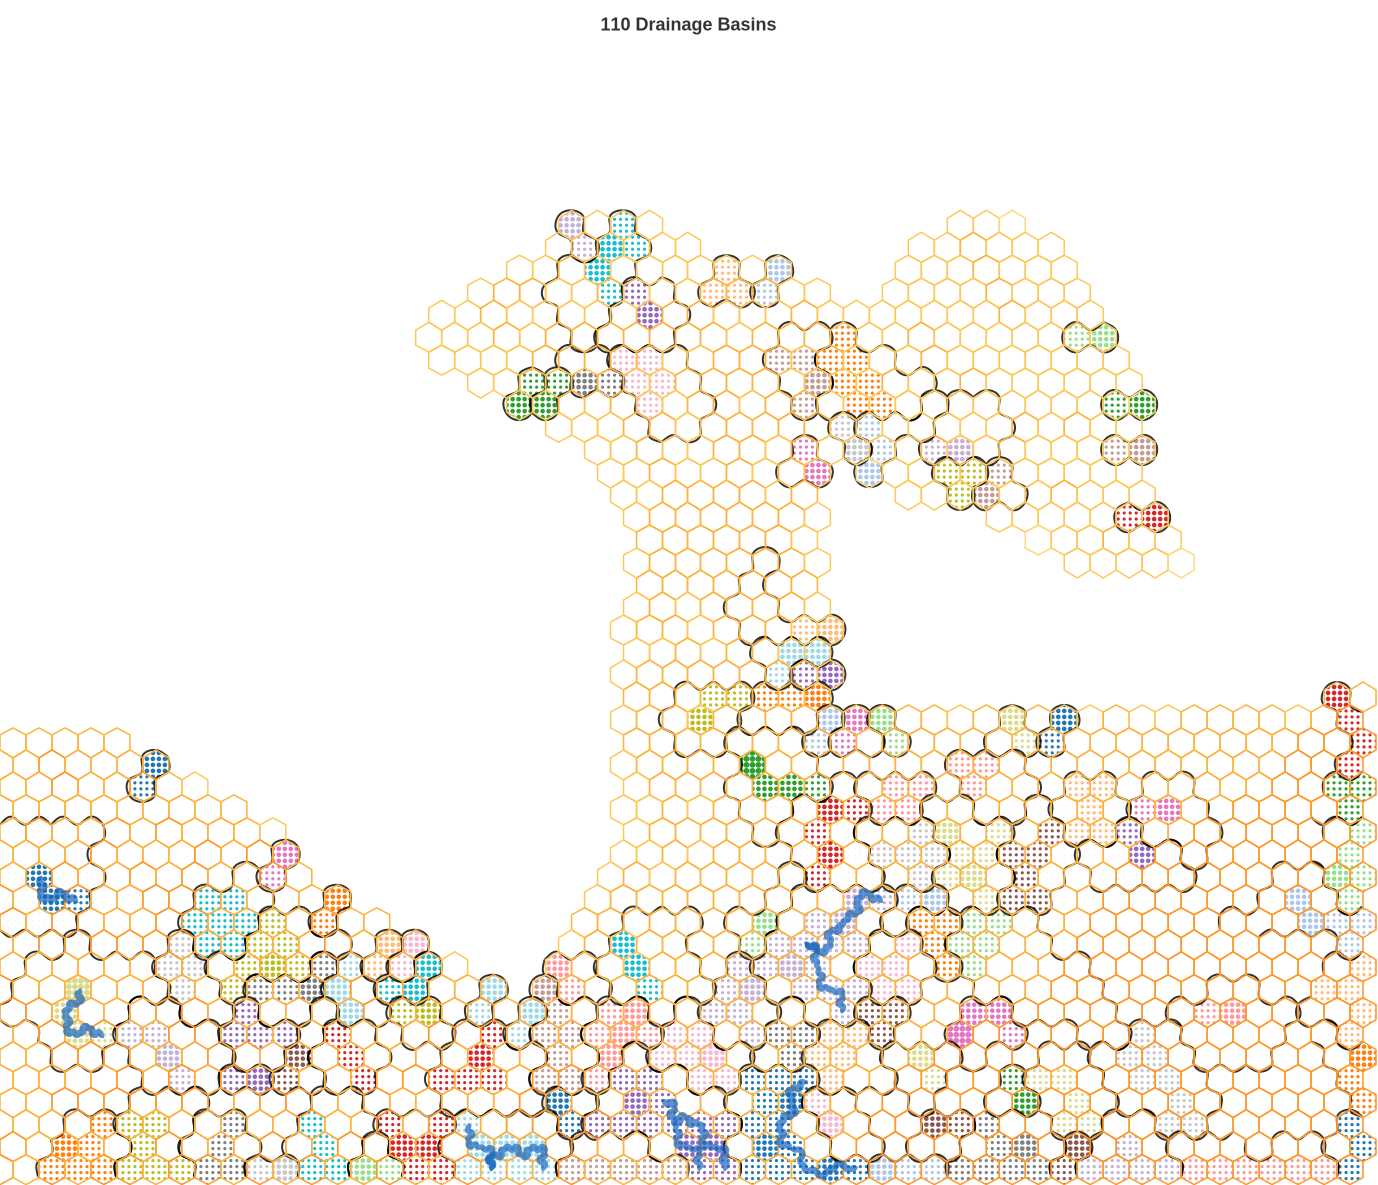

In [ ]:
TerraDemo().demoWatersheds()

## Lakes and end points

In [ ]:
#| export
@patch
def lake_basin(self: Watershed, flow_per_hex: float = 100.0) -> HexRegion:
    """
    Create a lake basin at the terminal hex based on accumulated flow.
    
    The lake grows by adding the lowest neighboring hexes that drain into it,
    until the total flow is "used up" by the lake area.
    
    Args:
        flow_per_hex: How much flow each hex of lake can hold (default: 100)
                     Lower values = bigger lakes
    
    Returns:
        HexRegion representing the lake basin
    """
    terminal = self.terminal_hex
    if terminal is None:
        return HexRegion(hexes=set(), hex_grid=self.terrain.hexGrid)

    there = self.terrain

    if there is None:
        print("Error: There is no terrain data available.")
        
        return HexRegion(hexes=set(), hex_grid=self.terrain.hexGrid)
    
    
    # Calculate how many hexes the lake should have
    flows = self.tributary._calculate_flow()
    terminal_flow = flows.get(terminal, 0)
    target_hexes = max(1, int(terminal_flow / flow_per_hex))
    
    # Start with terminal hex
    lake_hexes = {terminal}
    candidates = []  # (elevation, hex_idx)
    
    # Add neighbors as candidates
    for neighbor in self.terrain.hexGrid.neighborsOf(terminal):
        if neighbor >= 0 and neighbor in self.region.hexes:
            candidates.append((self.terrain.elevations[neighbor], neighbor))
    
    # Grow lake by adding lowest neighbors
    import heapq
    heapq.heapify(candidates)
    
    while len(lake_hexes) < target_hexes and candidates:
        elev, hex_idx = heapq.heappop(candidates)
        
        if hex_idx in lake_hexes:
            continue
        
        lake_hexes.add(hex_idx)
        
        # Add this hex's neighbors as new candidates
        for neighbor in self.terrain.hexGrid.neighborsOf(hex_idx):
            if neighbor >= 0 and neighbor not in lake_hexes and neighbor in self.region.hexes:
                heapq.heappush(candidates, (self.terrain.elevations[neighbor], neighbor))
    
    return HexRegion(hexes=lake_hexes, hex_grid=self.terrain.hexGrid)


In [ ]:
#| export
@patch
def drawRiver(self: Watershed, 
         min_width: float = 1.0,
         max_width: float = 8.0,
         min_windiness: float = 0.05,
         max_windiness: float = 0.3,
         min_iterations: int = 2,
         max_iterations: int = 5,
         color: str = "#1565c0",
         opacity: float = 0.7,
         debug: bool = False) -> str:
    """Render river with flow-based thickness and gradient-based windiness."""
    
    flows = self.tributary._calculate_flow()
    if not flows:
        return ""
    
    terrain = self.tributary.terrain
    max_flow = max(flows.values())
    log_max_flow = math.log10(max_flow + 1)
    
    ret = ""
    
    for hexes in self.segments():
        points = self.segment_to_points(hexes)
        
        if len(points) < 2:
            continue
        
        # Calculate gradient from elevation difference
        land_hexes = [h for h in hexes if terrain.elevations[h] > 0]
        if len(land_hexes) >= 2:
            gradient = terrain.elevations[land_hexes[0]] - terrain.elevations[land_hexes[-1]]
        else:
            gradient = 0
        
        # Calculate average flow (log scaled)
        segment_flows = [flows.get(h, 1) for h in land_hexes]
        avg_flow = sum(segment_flows) / len(segment_flows) if segment_flows else 1
        log_flow = math.log10(avg_flow + 1)
        flow_ratio = log_flow / log_max_flow if log_max_flow > 0 else 0
        
        # Map flow to width
        width = round(min_width + flow_ratio * (max_width - min_width), 1)
        
        # Map gradient to windiness (high gradient = less windy)
        max_possible_gradient = max(terrain.elevations) - min(e for e in terrain.elevations if e > 0)
        if max_possible_gradient > 0:
            gradient_ratio = min(gradient / max_possible_gradient, 1.0)
            windiness_ratio = 1.0 - gradient_ratio
        else:
            windiness_ratio = 0.5
        
        offset_factor = min_windiness + windiness_ratio * (max_windiness - min_windiness)
        iterations = int(min_iterations + windiness_ratio * (max_iterations - min_iterations))
        
        if debug:
            print(f"Segment: {len(hexes)} hexes, gradient={gradient:.0f}, "
                  f"width={width:.1f}, windiness={offset_factor:.2f}")
        
        # Create and draw path
        aPath = MapPath(points, style=StyleCSS("dummy"))
        windy = aPath.make_windy(iterations=iterations, offset_factor=offset_factor)
        
        inline_style = f"fill:none;stroke:{color};stroke-width:{width};opacity:{opacity}"
        ret += windy.drawSpline(adds=f'style="{inline_style}"')
    
    return ret

In [ ]:
#| export
@patch
def drawLake(self:Watershed)->str:
    if self.is_ocean:
        return ""
    
    lake = self.lake_basin()
    
    if not lake.hexes:
        return ""
    
    # Create a new style for the lake
    lake_style = StyleCSS(
        f"lake_",
        fill="#0000ff",  # Blue color for the lake
        opacity=0.5,  # Adjust opacity as needed
        stroke="none"
    )
    
    self.terrain.builder.add_style(lake_style)  
    return self.terrain.styleRegion(lake,lake_style)
    

In [ ]:
#| export
@patch
def draw(self: Watershed, 
         min_width: float = 1.0,
         max_width: float = 8.0,
         min_windiness: float = 0.05,
         max_windiness: float = 0.3,
         min_iterations: int = 2,
         max_iterations: int = 5,
         color: str = "#1565c0",
         opacity: float = 0.7,
         debug: bool = False) -> str:

        rivers = self.drawRiver(
                min_width = min_width,
                max_width =  max_width,
                min_windiness = min_windiness,
                max_windiness = max_windiness,
                min_iterations  =  min_iterations,
                max_iterations = max_iterations,
                color =color,
                opacity = opacity,
                debug = debug
                )

        rivers += self.drawLake()
        return rivers

In [ ]:
@patch
def demoLakes(self: TerraDemo):
    """Demo showing watersheds colored by drainage basin."""
    
    # Create simplified island terrain
    terrain = self.simpleIsland()
    terrain.hexGrid.update(layer_name="elevations")
    
    # Compute all watersheds
    basin = DrainageBasins(terrain)

     
    
    terrain.hexGrid.builder.adjust("watersheds", basin.dotted_watershed_overlay(min_density=0.5))
    #terrain.hexGrid.builder.adjust("watershed_boundaries", basin.boundary_overlay())
    terrain.hexGrid.builder.adjust("borders",terrain.elevation_borders())

       # Add gradient flow lines
    gradient_overlay = basin.gradient_overlay(
        min_width=0.5,
        max_width=4.0,
        opacity=0.7
    )
    #terrain.hexGrid.builder.adjust("gradient_flow", gradient_overlay)


    river_style = StyleCSS(
        "nile",
        fill = "none",
        
        stroke= '#cad1d829',
        stroke_width=3,
        opacity= 0.7
    )
    
    terrain.hexGrid.builder.add_style(river_style)
    river_svg = ""
    #print(basin.terrain)
    rivers = basin.get_major(6)
    
    for river in rivers:
        small_river = river.simplify(2)
        #print(small_river.terrain, river.terrain)
        if river.terrain is not None:
            small_river.tributary.terrain = terrain
            river_svg += small_river.draw()


    terrain.hexGrid.builder.adjust("rivers", river_svg)

    watersheds = basin.sheds
    
    # Add legend showing watershed count
    legend_text = f"{len(watersheds)} Drainage Basins"
    
    terrain.hexGrid.builder.add_centered_text(
        legend_text, 
        y_offset=-terrain.hexGrid.builder.height/2 + 30,
        class_name="watershed_legend"
    )
    
    legend_style = StyleCSS("watershed_legend",
                           fill="#333333",
                           font_size="18px",
                           font_weight="bold",
                           font_family="Arial, sans-serif")
    terrain.hexGrid.builder.add_style(legend_style)
    
    return terrain.hexGrid.builder.show()

Initial seeds: 25 (spacing=11)
After elimination: 16
Final unique seeds: 16


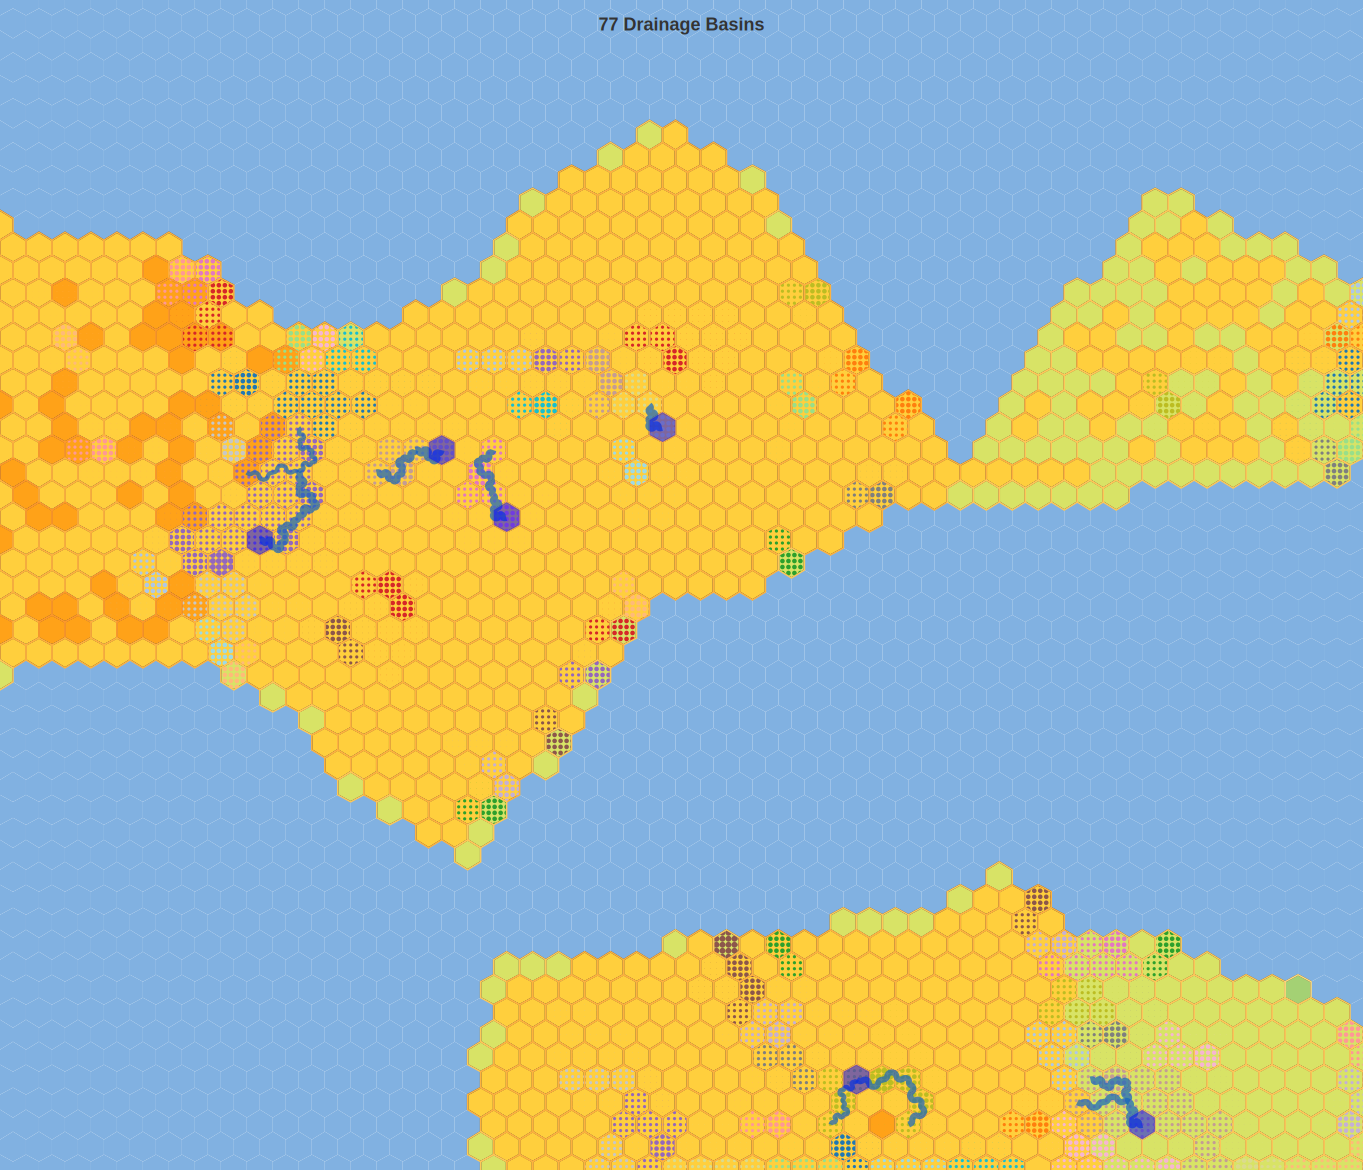

In [ ]:
TerraDemo().demoLakes()